# 任务描述

- 设计回归器用于房价预测。


# 数据描述

##  [Boston House Prices (Boston)](https://www.kaggle.com/vikrishnan/boston-house-prices)

In [1]:
from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
print(X[:3])
print(y[:3])

[[6.3200e-03 1.8000e+01 2.3100e+00 0.0000e+00 5.3800e-01 6.5750e+00
  6.5200e+01 4.0900e+00 1.0000e+00 2.9600e+02 1.5300e+01 3.9690e+02
  4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 6.4210e+00
  7.8900e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9690e+02
  9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 0.0000e+00 4.6900e-01 7.1850e+00
  6.1100e+01 4.9671e+00 2.0000e+00 2.4200e+02 1.7800e+01 3.9283e+02
  4.0300e+00]]
[24.  21.6 34.7]


## [UK House Prices (UK)](https://github.com/datasets/house-prices-uk)


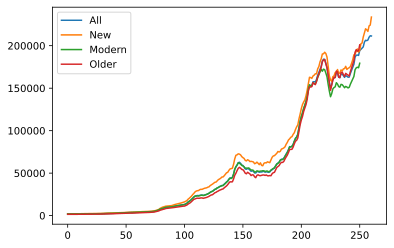

In [2]:
%config InlineBackend.figure_format = 'svg'
import pandas as pd
import matplotlib.pyplot as plt
data_uk = pd.read_csv('house-prices-uk.csv')
data_uk = data_uk.drop(list(filter(lambda c : c.startswith('Change'),
                                   list(data_uk.columns))) + ['Date'], axis=1)
data_uk_col = list(data_uk.columns)
data_uk = [data_uk[col].values for col in data_uk_col]
data_uk[2] = data_uk[2][:-10]
data_uk[3] = data_uk[3][:-10]
data_uk_col = [col.split()[1][1:-1] for col in data_uk_col]
l = [plt.plot(data)[0] for data in data_uk]
plt.legend(handles=l, labels=data_uk_col)
plt.show()

# 数据预处理

对于Boston数据集，本报告使用的数据预处理方法仅仅是将每一列的值全部“缩放”至$[0,50]$的范围内：

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(1)  # make sure that the train-test-split is always the same
X = X / np.max(X, axis=0) * 50  # scale the input to [0, 50]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

对于UK数据集，本报告使用的数据预处理方法是对每个值取对数，于是得到的房价变化趋势接近线性：

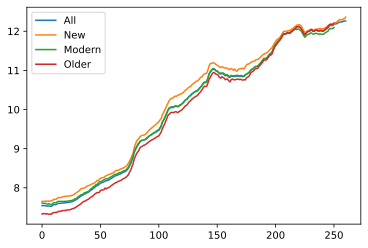

In [4]:
%config InlineBackend.figure_format = 'svg'
import numpy as np
from sklearn.model_selection import train_test_split
np.random.seed(1)

data_uk = [np.log(data) for data in data_uk]
l = [plt.plot(data)[0] for data in data_uk]
plt.legend(handles=l, labels=data_uk_col)
plt.show()

data_uk = [np.array(list(enumerate(data))) for data in data_uk]
data_uk = [(data[:, 0], data[:, 1]) for data in data_uk]
data_uk = [train_test_split(data[0], data[1], test_size=0.2)
           for data in data_uk]
data_uk = [(data[0].reshape((-1, 1)), data[1].reshape((-1, 1)),
            data[2], data[3]) for data in data_uk]

# 算法介绍

## 线性回归

### 算法原理

线性回归的数学表达式为：

$$\hat{y}=w_0+\sum_{j=1}^{M}{w_j X_j}$$

其中，$\boldsymbol{w}=(w_0,w_1,\cdots,w_M)$是模型参数，$\boldsymbol{X}=(X_1,X_2,\cdots\,X_M)$是模型输入，$\hat{y}$是模型输出。

令$X_0=1$，则

$$\hat{y}=\sum_{j=0}^{M}{w_j X_j}$$

假设训练集：

$$\mathscr{D}=\{(\boldsymbol{X}_i, y_i)\}_{i=1}^N$$

其中$N$为训练集中的数据总量。

定义平方损失函数为：

$$\begin{aligned}\ell&=\sum_{i=1}^N{\left(\hat{y_i}-y_i\right)^2}\\
&=\sum_{i=1}^N{\left(\sum_{j=0}^{M}{w_j X_{i,j}}-y_i\right)^2}\end{aligned}$$

最小化平方损失函数即可得到模型的一组参数$\boldsymbol{w}^{\star}$。

为求得模型的一组参数，使用梯度下降法迭代更新模型参数：

$$\delta_k=\frac{\partial\ell}{\partial w_k}=2\sum_{i=1}^N{\left(\sum_{j=0}^{M}{w_j X_{i,j}}-y_i\right)\cdot X_{i,k}}$$

$$w_k\leftarrow w_k-\eta\cdot\delta_k$$

其中，$\eta$为学习率。

也可以定义lasso损失函数：

$$\begin{aligned}\ell^{[1]}&=\sum_{i=1}^N{\left(\hat{y_i}-y_i\right)^2}+\alpha\sum_{j=0}^M{\lvert w_j\rvert}\\
&=\ell+\alpha\sum_{j=0}^M{\lvert w_j\rvert}\end{aligned}$$

此时，模型参数更新公式为：

$$\delta_k^{[1]}=\frac{\partial\ell^{[1]}}{\partial w_k}=\delta_k+\alpha\cdot sign\left(w_k\right)$$

$$w_k\leftarrow w_k-\eta\cdot\delta_k^{[1]}$$

其中，$sign(x)=\left\{\begin{matrix}-1&x<0\\0&x=0\\1&x>0\end{matrix}\right.$

或定义ridge损失函数：

$$\begin{aligned}\ell^{[2]}&=\sum_{i=1}^N{\left(\hat{y_i}-y_i\right)^2}+\alpha\sum_{j=0}^M{w_j^2}\\
&=\ell+\alpha\sum_{j=0}^M{w_j^2}\end{aligned}$$

此时，模型参数更新公式为：

$$\delta_k^{[2]}=\frac{\partial\ell^{[2]}}{\partial w_k}=\delta_k+2\alpha\cdot w_k$$

$$w_k\leftarrow w_k-\eta\cdot\delta_k^{[2]}$$



### 算法实现

In [5]:
import numpy as np
from sklearn.metrics import mean_squared_error


class LinearRegression:
    
    def __init__(self):
        self.w = None
    
    def fit(self, X, y,
            regularization=None, alpha=1.0,
            eta=0.001, gamma=0.9, eps=1e-12, epochs=5000):
        n, m = X.shape
        w = np.random.randn(m + 1)
        best_w = None
        best_loss = 0
        X = np.concatenate([X, np.ones((n, 1))], axis=-1)
        s = np.zeros(m + 1)
        for _ in range(epochs):
            if regularization is None:
                term = 0
            elif regularization == 'lasso':
                term = alpha * np.sign(w)
            elif regularization == 'ridge':
                term = 2.0 * alpha * w
            else:
                raise AttributeError
            pred = np.sum(X * w, axis=-1)
            rmse = np.sqrt(mean_squared_error(y, pred))
            if best_w is None or rmse < best_loss:
                best_loss = rmse
                best_w = np.array(w)
            # RMSprop is used
            # gradients
            g = (2.0 * np.sum((pred - y)
                              .reshape((-1, 1)) * X,
                              axis=0) / n + term) / m
            # accumulations
            s = gamma * s + (1 - gamma) * g * g
            # update parameters
            w -= eta / np.sqrt(s + eps) * g
        self.w = best_w
        return self
    
    def predict(self, X):
        assert self.w is not None, 'Model is not trained.'
        n, m = X.shape
        assert m + 1 == self.w.shape[0], 'Input shape mismatched.'
        X = np.concatenate([X, np.ones((n, 1))], axis=-1)
        return np.sum(X * self.w, axis=-1)

## 决策树

### 算法原理

决策树是一种树结构，构造是一个递归的过程。

从树根$root$开始，对于训练集

$$\mathscr{D}_{root}=\left\{(\boldsymbol{X}_i,y_i)\right\}_{i=1}^N$$

需要将其拆分成两部分，拆分标准记为$\theta=(k,v)$，拆分的两部分数据分别为：

$$\mathscr{D}_{left}=\left\{(\boldsymbol{X}_i,y_i)\right\}\wedge X_{i,k}\le v$$
$$\mathscr{D}_{right}=\mathscr{D}_{root}\backslash\mathscr{D}_{left}$$

对于回归问题，定义纯度函数为数据集中标签的方差：

$$\overline{y}=\frac{1}{\lvert\mathscr{D}\rvert}\sum_{i=1}^{\lvert\mathscr{D}\rvert}{y_i}$$
$$H(\mathscr{D})=\frac{1}{\lvert\mathscr{D}\rvert}\sum_{i=1}^{\lvert\mathscr{D}\rvert}{\left(y_i-\overline{y}\right)^2}$$

其中，$\lvert\mathscr{D}\rvert$表示数据集大小。

定义：

$$G(\mathscr{D},\theta)=\lvert\mathscr{D}_{left}\rvert H(\mathscr{D}_{left})+\lvert\mathscr{D}_{right}\rvert H(\mathscr{D}_{right})$$

通过选择合适的$\theta$使得$G(\mathscr{D},\theta)$函数值最小，得到拆分点：

$$\theta^{\star}=\mathop{\arg\min_{\theta}}G(\mathscr{D},\theta)$$

随后，继续递归处理$\mathscr{D}_{left}$与$\mathscr{D}_{right}$。

当数据集中所有数据的标签都相同时，递归结束。

### 算法实现

In [6]:
import numpy as np
from graphviz import Digraph


class DecisionTree:
    
    def __init__(self):
        self.root = {}
    
    @staticmethod
    def __calc(X, y):
        n, = y.shape
        if n == 0:
            return 0
        return n * np.var(y)
    
    def __build(self, node, X, y):
        n, m = X.shape
        # boundary: all labels have the same value
        if np.unique(y).shape[0] == 1:
            node['content'] = (X, y)
            return
        best_theta = None
        best_value = 0
        # enumerate all the possible partitions
        for k in range(m):
            for v in np.unique(X[:, k]):
                left = X[:, k] <= v
                X_left = X[left]
                y_left = y[left]
                right = X[:, k] > v
                X_right = X[right]
                y_right = y[right]
                value = self.__calc(X_left, y_left) + \
                        self.__calc(X_right, y_right)
                if best_theta is None or value < best_value:
                    best_theta = (k, v)
                    best_value = value
        k, v = best_theta
        left = X[:, k] <= v
        right = X[:, k] > v
        # ensure left is non-empty
        if np.sum(left) == 0:
            left, right = right, left
        # boundary: one child is empty
        # it is impossible that both children are empty,
        # since the input is non-empty
        if np.sum(right) == 0:
            node['content'] = (X, y)
            return
        X_left = X[left]
        y_left = y[left]
        X_right = X[right]
        y_right = y[right]
        node['param'] = best_theta
        node['left'] = {}
        node['right'] = {}
        self.__build(node['left'], X_left, y_left)
        self.__build(node['right'], X_right, y_right)
    
    def __predict_one(self, node, X):
        if 'content' in node:
            return np.mean(node['content'][1])
        k, v = node['param']
        if X[k] <= v:
            return self.__predict_one(node['left'], X)
        else:
            return self.__predict_one(node['right'], X)
    
    def fit(self, X, y):
        self.__build(self.root, X, y)
        return self
    
    def predict(self, X):
        n, _ = X.shape
        res = np.zeros(n)
        for i in range(n):
            res[i] = self.__predict_one(self.root, X[i])
        return res
    
    def __export(self, node, g):
        cur_id = node['id']
        if 'content' in node:
            g.node(str(cur_id), label='{:.2f}' \
                   .format(np.mean(node['content'][1])))
            return
        k, v = node['param']
        g.node(str(cur_id), label='X[{}] ? {:.2f}'.format(k, v))
        left = node['left']
        right = node['right']
        left['id'] = self.num
        self.num += 1
        right['id'] = self.num
        self.num += 1
        g.edge(str(cur_id), str(left['id']), label='<=')
        g.edge(str(cur_id), str(right['id']), label='>')
        self.__export(left, g)
        self.__export(right, g)
    
    def export_graphviz(self):
        g = Digraph()
        self.root['id'] = 0
        self.num = 1
        self.__export(self.root, g)
        return g

测试决策树的可视化功能：

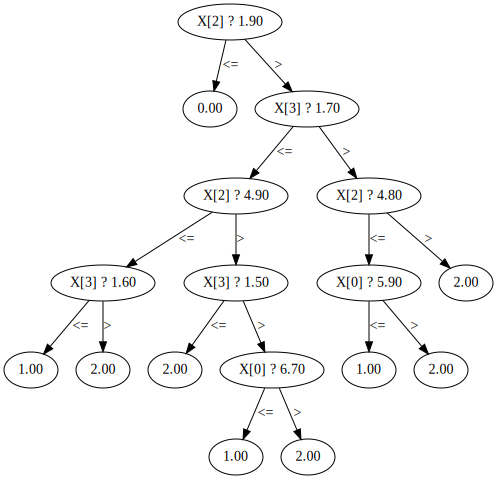

In [7]:
from sklearn.datasets import load_iris
X_iris, y_iris = load_iris(return_X_y=True)
DecisionTree().fit(X_iris, y_iris).export_graphviz()

## SVR

### 算法原理

SVR是支持向量机（SVM）的回归器版本，假设训练集：

$$\mathscr{D}=\{(\boldsymbol{X}_i, y_i)\}_{i=1}^N$$

其中，$\boldsymbol{X}_i=(X_{i,1},X_{i,2},\cdots\,X_{i,M})$是训练集的特征向量，$y_i$是训练集的标签。

SVR的目标是找到一个超平面，使得该平面尽可能通过所有点。

因此该模型的参数有$\boldsymbol{w}=(w_1,w_2,\cdots,w_M)$和$b$。

但通常情况下，该平面是不存在的（不能保证没有噪声干扰）。

为了解决这个问题，可以允许每个数据点与该平面之间存在一定偏差$\varepsilon$。

如果偏差超过$\varepsilon$，则增加一个惩罚项（系数为$C$）。

目标就是找到一个模长最小的超平面：
$$\min_{\boldsymbol{w},b}{\sum_{j=1}^M{w_j^2}+C\sum_{i=1}^N{\left(\xi_i+\xi_i^{*}\right)}}$$

满足以下约束条件：
$$y_i-\sum_{j=1}^M{w_j\phi(X_{i,j})}-b\le\varepsilon+\xi_i$$
$$\sum_{j=1}^M{w_j\phi(X_{i,j})}+b-y_i\le\varepsilon+\xi_i^{*}$$
$$\xi_i,\xi_i^{*}\ge 0,i=1,\cdots,N$$

其中，$\phi(\cdot)$是核函数，用于将非线性关系映射到线性空间。

SVR的优化过程比较复杂，本报告直接调用scikit-learn中的SVR完成实验。


# 实验结果与分析

## 基准性能测试

基准性能测试的目的是确保本报告实现的模型与sklearn中的模型性能相当：

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression as LiR, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

print('standard linear regression')
np.random.seed(1)
pred = LinearRegression().fit(X_train, y_train).predict(X_test)
print('my implementation:', np.sqrt(mean_squared_error(y_test, pred)))
pred = LiR().fit(X_train, y_train).predict(X_test)
print('sklearn:', np.sqrt(mean_squared_error(y_test, pred)))
print()

print('lasso')
np.random.seed(1)
pred = LinearRegression()\
    .fit(X_train, y_train, regularization='lasso', alpha=1.0).predict(X_test)
print('my implementation:', np.sqrt(mean_squared_error(y_test, pred)))
pred = Lasso(alpha=1.0).fit(X_train, y_train).predict(X_test)
print('sklearn:', np.sqrt(mean_squared_error(y_test, pred)))
print()

print('ridge')
np.random.seed(1)
pred = LinearRegression()\
    .fit(X_train, y_train, regularization='ridge', alpha=1.0).predict(X_test)
print('my implementation:', np.sqrt(mean_squared_error(y_test, pred)))
pred = Ridge(alpha=1.0).fit(X_train, y_train).predict(X_test)
print('sklearn:', np.sqrt(mean_squared_error(y_test, pred)))
print()

print('decision tree')
np.random.seed(1)
pred = DecisionTree().fit(X_train, y_train).predict(X_test)
print('my implementation:', np.sqrt(mean_squared_error(y_test, pred)))
pred = DecisionTreeRegressor().fit(X_train, y_train).predict(X_test)
print('sklearn:', np.sqrt(mean_squared_error(y_test, pred)))

standard linear regression
my implementation: 4.681826352831037
sklearn: 4.835373458200536

lasso
my implementation: 4.741457075827274
sklearn: 4.971531681847167

ridge
my implementation: 4.747478156405433
sklearn: 4.835486222540877

decision tree
my implementation: 4.071698108921642
sklearn: 5.656334294139521


## 实验结果

对于标准线性回归和决策树，没有额外的参数；

对于lasso和ridge，$\alpha\in\left\{0.1,0.2,\cdots,1.0\right\}$；

对于SVR，$C\in\left\{100,200,300,400,500\right\}$与$\varepsilon\in\left\{0.1,0.2,0.3,0.4,0.5\right\}$。

实验代码与实验结果如下：

In [ ]:
from sklearn.svm import SVR

print('Linear Regression')

def evaluate_lir(X_train_set, y_train_set,
                 X_test_set, y_test_set, regularization):
    best = np.inf
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        np.random.seed(1)
        pred = LinearRegression().fit(X_train_set, y_train_set,
                                      regularization=regularization,
                                      alpha=alpha).predict(X_test_set)
        res = np.sqrt(mean_squared_error(y_test_set, pred))
        if res < best:
            best = res
    return best

print('Boston')
for regularization in ['lasso', 'ridge']:
    print(regularization, evaluate_lir(X_train, y_train,
                                       X_test, y_test,
                                       regularization))
print()
print('UK')
for name, (X_train_uk, X_test_uk, y_train_uk, y_test_uk) \
    in zip(data_uk_col, data_uk):
    print(name)
    for regularization in [None, 'lasso', 'ridge']:
        print(regularization, evaluate_lir(X_train_uk, y_train_uk,
                                           X_test_uk, y_test_uk,
                                           regularization))
print()
print('*' * 30)
print()
print('Decision Tree')
print('UK')
for name, (X_train_uk, X_test_uk, y_train_uk, y_test_uk) \
    in zip(data_uk_col, data_uk):
    pred = DecisionTree().fit(X_train_uk, y_train_uk).predict(X_test_uk)
    res = np.sqrt(mean_squared_error(y_test_uk, pred))
    print(name, ':', res)
print()
print('*' * 30)
print()

print('SVR')

def evaluate_svr(X_train_set, y_train_set,
                 X_test_set, y_test_set):
    best = np.inf
    for C in [100, 200, 300, 400, 500]:
        for epsilon in [0.1, 0.2, 0.3, 0.4, 0.5]:
            np.random.seed(1)
            pred = SVR(C=C, epsilon=epsilon) \
                .fit(X_train_set, y_train_set).predict(X_test_set)
            res = np.sqrt(mean_squared_error(y_test_set, pred))
            if res < best:
                best = res
    return best

print('Boston', evaluate_svr(X_train, y_train, X_test, y_test))
for name, (X_train_uk, X_test_uk, y_train_uk, y_test_uk) \
    in zip(data_uk_col, data_uk):
    print(name, evaluate_svr(X_train_uk, y_train_uk,
                             X_test_uk, y_test_uk))

|模型|Boston|UK (All)|UK (New)|UK (Modern)|UK (Older)|
|:-:|:-:|:-:|:-:|:-:|:-:|
|线性回归|4.68|3.11|3.11|3.08|2.77|
|Lasso|4.67|3.10|3.10|3.08|2.77|
|Ridge|4.69|3.10|3.09|3.07|2.76|
|决策树|4.07|**0.04**|**0.05**|**0.03**|**0.04**|
|SVR|**2.63**|0.08|0.08|0.08|0.09|

从实验结果来看，SVR在Boston数据集上取得最好的预测效果，决策树在UK数据集上取得最好的预测效果。


## 结果分析

以UK (ALL)为例，决策树可以取得更好的预测效果，是因为该数据集中的数据，被随机分为训练集与测试集。

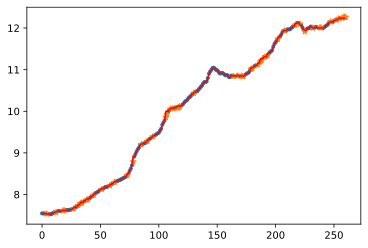

In [9]:
%config InlineBackend.figure_format = 'svg'
X_train_uk, X_test_uk, y_train_uk, y_test_uk = \
    data_uk[0]
X_min = min(np.min(X_test_uk), np.min(X_train_uk))
X_max = max(np.max(X_test_uk), np.max(X_train_uk))
pred = DecisionTree().fit(X_train_uk, y_train_uk) \
    .predict((np.arange(X_max) + X_min).reshape((-1, 1)))
plt.scatter(X_train_uk.reshape(-1), y_train_uk, marker='.')
plt.scatter(X_test_uk.reshape(-1), y_test_uk, marker='*')
plt.plot(pred, color='r')
plt.show()

如图所示，蓝色的点是训练集数据，橙色的星是测试集数据，红色曲线是决策树的预测结果。

由于测试集的数据足够密集，决策树只需直接返回训练集中的数据，就可以达到很好的效果。

同时，线性回归不可能找到一个直线，完美拟合所有点，因此效果肯定会差于决策树：

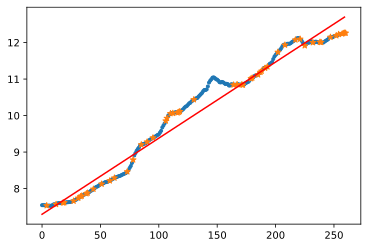

In [10]:
%config InlineBackend.figure_format = 'svg'
pred = LinearRegression().fit(X_train_uk,
                              y_train_uk,
                              epochs=10000) \
    .predict((np.arange(X_max) + X_min).reshape((-1, 1)))
plt.scatter(X_train_uk.reshape(-1), y_train_uk, marker='.')
plt.scatter(X_test_uk.reshape(-1), y_test_uk, marker='*')
plt.plot(pred, color='r')
plt.show()

对于SVR，由于使用了核函数，导致其有更好的拟合效果：

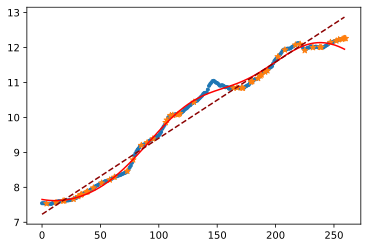

In [11]:
%config InlineBackend.figure_format = 'svg'
from sklearn.svm import SVR
plt.scatter(X_train_uk.reshape(-1), y_train_uk, marker='.')
plt.scatter(X_test_uk.reshape(-1), y_test_uk, marker='*')
pred = SVR().fit(X_train_uk, y_train_uk) \
    .predict((np.arange(X_max) + X_min).reshape((-1, 1)))
plt.plot(pred, color='r')
pred = SVR(kernel='linear').fit(X_train_uk, y_train_uk) \
    .predict((np.arange(X_max) + X_min).reshape((-1, 1)))
plt.plot(pred, color='darkred', linestyle='--')
plt.show()

深红色虚线是使用线性核函数拟合得到的SVR，红色实线是使用RBF核函数拟合得到的SVR。

最后，**本报告通过将RBF核函数与线性回归结合，提升线性回归的拟合效果**。

RBF核函数的形式是：

$$K(\boldsymbol{x},\boldsymbol{x'})=e^{-\frac{\left\|\boldsymbol{x}-\boldsymbol{x'}\right\|^2}{\sigma}}$$

可以作为$\boldsymbol{x}$与$\boldsymbol{x'}$的相似度。

使用时，从训练集中随机选取$m$个点，所有输入的点都与这$m$个点计算相似度，可以得到一个$m$维向量。

对于一些低维线性不可分的数据，用这种方法升维以后，在高维空间可能近似达到线性可分。

相比朴素的线性回归，使用RBF核函数的线性回归有更好的拟合效果：

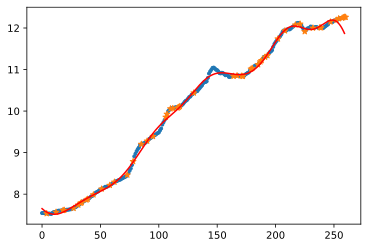

RMSE: 0.11506834252776313


In [12]:
%config InlineBackend.figure_format = 'svg'

n_features = 100  # number of features
X_train_uk_T0 = X_train_uk / X_max  # scale to [0, 1]
# the first n_features points are selected
ll = [X_train_uk_T0[ii] for ii in range(n_features)]

# kernel function
def phi(X_input, l):
    return np.exp(-(X_input - l) ** 2 / 0.01) * 1e-1

# transform an arbitrary dimensional input vector
# to an n_features dimensional vector
def transform(X_input):
    return np.concatenate([phi(X_input, ll[ii])
                           for ii in range(n_features)],
                          axis=-1)

X_train_uk_T = transform(X_train_uk_T0)
X_test_uk_T = transform((np.arange(X_max) + X_min)
                        .reshape((-1, 1)) / X_max)

np.random.seed(1)
linear_regression = LinearRegression().fit(X_train_uk_T,
                                           y_train_uk,
                                           epochs=20000)

pred = linear_regression.predict(X_test_uk_T)
plt.scatter(X_train_uk.reshape(-1), y_train_uk, marker='.')
plt.scatter(X_test_uk.reshape(-1), y_test_uk, marker='*')
plt.plot(pred, color='r')
plt.show()

X_test_uk_T = transform(X_test_uk / X_max)
pred = linear_regression.predict(X_test_uk_T)
print('RMSE:', np.sqrt(mean_squared_error(y_test_uk, pred)))

# 参考链接

- [线性回归](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso)
- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)
- [RMSprop](http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
- [决策树](https://scikit-learn.org/stable/modules/tree.html#tree-algorithms-id3-c4-5-c5-0-and-cart)
- [Scikit-learn: SVR](https://scikit-learn.org/stable/modules/svm.html#svr)
- [MathWorks: SVR](https://www.mathworks.com/help/stats/understanding-support-vector-machine-regression.html)
- [核函数](https://scikit-learn.org/stable/modules/svm.html#kernel-functions)